In [1]:
import sys
sys.path.append('../..')

ansatz_id   = 1    # 1:hardware, 2:ising, 3:eh2d, 4:mi

# ===== 1. 配置参数 =====
train_csv   = "../../data_2d/train.csv"
test_csv    = "../../data_2d/test.csv"
unseen_csv  = "../../data_2d/unseen.csv"
params_npy  = f"../../data/results/result{ansatz_id}/params.npy" 
shots       = 10_000


# ===== 2. 导入依赖 =====
import os, json, itertools, pathlib
import numpy as np
import pandas as pd
import jax, jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import pennylane as qml
from src.train.training import ansatz_set
from src.train.qcbm import QCBM
from src.train.mmdagg_probs import *

sys.path.append("../..")
from src.circuits.ansatz1 import hardware_efficient_ansatz
from src.circuits.ansatz2 import ising_structured_ansatz
from src.circuits.ansatz3 import eh2d_ansatz
from src.circuits.ansatz4 import mi_ansatz

# 假设 QCBM, ansatz_set, mmdagg_prob 已定义或 import
# from src.qcbm import QCBM, ansatz_set, mmdagg_prob
n_qubits = 8
bit_cols = [f"q{i}" for i in range(n_qubits)]
shape     = (2, 4)
beta, J   = 0.7, 1.0
rng       = np.random.default_rng(0)

train_df = pd.read_csv(train_csv, dtype=str)  # 强制所有列都读为字符串，防止变成int/float
all_bits = [''.join(seq) for seq in itertools.product('01', repeat=n_qubits)]


# ---------- 1. 生成所有 256 个比特串 ----------
bits256 = np.array(list(itertools.product([0, 1], repeat=n_qubits)))  # (256,8)
spins   = 2*bits256 - 1                                              # {-1,+1}

# ---------- 2. 2D Ising 能量 ----------
# 将线性索引 → (row,col)
def idx2rc(idx, shape):
    r, c = divmod(idx, shape[1]); return r, c

nbrs = [[] for _ in range(n_qubits)]
for i in range(n_qubits):
    r, c = idx2rc(i, shape)
    if r+1 < shape[0]:  nbrs[i].append(i + shape[1])   # ↓ neighbour
    if c+1 < shape[1]:  nbrs[i].append(i + 1)          # → neighbour


def E2d(s):
    e = 0.0
    for i in range(n_qubits):
        for j in nbrs[i]:
            e -= J * s[i] * s[j]
    return e

E = np.array([E2d(s) for s in spins])
p_unnorm = np.exp(-beta*E); p_unnorm /= p_unnorm.sum()


ansatz_map = {
    1: hardware_efficient_ansatz,
    2: ising_structured_ansatz,
    3: eh2d_ansatz,
    4: mi_ansatz
}
all_results = []
for id in range(1, 5, 1):
    params_npy  = f"../../data/results/result{id}/params.npy" 
    params = np.load(params_npy)
    ansatz = ansatz_map[id]
    ansatz, L, pc, id = ansatz_set(ansatz)

    model = QCBM(
        ansatz=ansatz,
        n_qubits=n_qubits,
        L=L,
        mmd_fn=mmdagg_prob,
        target_probs=jnp.zeros(2**n_qubits),
        dtype=jnp.float64,
    )

    params = jnp.asarray(np.load(params_npy), dtype=jnp.float64)


    samples = model.circuit2(params)
    samples = np.asarray(samples)
    bs = [''.join(map(str, row)) for row in samples]
    S_set = set(all_bits)
    D_set = set(train_df["bitstring"].str.strip())
    G_train = [b for b in bs if b in D_set]
    G_new = [b for b in bs if b not in D_set]
    G_sol = [b for b in G_new if b in S_set]
    g_sol = set(G_sol)
    Q = len(bs) 
    p = (len(G_train) + len(G_sol)) / Q
    E = len(G_new) / Q
    e = len(D_set) / len(S_set)
    C = len(g_sol) / (len(S_set) - len(D_set))
    S_minus_D = len(S_set) - len(D_set)

    if S_minus_D > 0:
        C_ = 1 - (1 - 1 / S_minus_D) ** Q   # 理论最大覆盖（概率模型极优）
    else:
        C_ = 1.0

    C_tilde = C / C_ if C_ > 0 else 0.0
    if Q < len(S_set) * (1 - e) * 0.1:
        C_tilde = len(g_sol) / Q

    R = len(G_sol) / Q
    R_ = 1 - e
    R_title = R/R_ if R_ > 0 else 0.0    

    F = len(G_sol) / len(G_new)
    res = {
        "ansatz" : id,
        "shots": shots,
        "Fidelity": F,
        "Rate": R_title,
        "Coverage": C_tilde,
        "counts": {
            "|G_train|": len(G_train),
            "|G_new|": len(G_new),
            "|G_sol|": len(G_sol),
        }
    }
    all_results.append(res)
    import pprint
    pprint.pprint(res)
    output_path = f'../../data/results/result{id}/metrics.json'
    with open(output_path, 'w') as f:
        json.dump(res, f, indent=2)
big_json_path = '../../data/results/metrics.json'
with open(big_json_path, 'w') as f:
    json.dump(all_results, f, indent=2)

{'Coverage': 0.6647398843930635,
 'Fidelity': 1.0,
 'Rate': 0.2234450867052023,
 'ansatz': 1,
 'counts': {'|G_new|': 1510, '|G_sol|': 1510, '|G_train|': 8490},
 'shots': 10000}
{'Coverage': 0.5895953757225434,
 'Fidelity': 1.0,
 'Rate': 0.05845086705202312,
 'ansatz': 2,
 'counts': {'|G_new|': 395, '|G_sol|': 395, '|G_train|': 9605},
 'shots': 10000}
{'Coverage': 0.5317919075144508,
 'Fidelity': 1.0,
 'Rate': 0.04246936416184971,
 'ansatz': 3,
 'counts': {'|G_new|': 287, '|G_sol|': 287, '|G_train|': 9713},
 'shots': 10000}
{'Coverage': 0.9479768786127167,
 'Fidelity': 1.0,
 'Rate': 1.046492485549133,
 'ansatz': 4,
 'counts': {'|G_new|': 7072, '|G_sol|': 7072, '|G_train|': 2928},
 'shots': 10000}


In [ ]:
import numpy as np
import sys
from training import count_params1
from training import count_params2
from training import count_params3
from training import count_params4
sys.path.append('../..')
ansatz_id = 4
params_npy  = f"../../data/results/result{ansatz_id}/params.npy" 
print(params_npy)
params = jnp.asarray(np.load(params_npy), dtype=jnp.float64)
print("params.shape", params.shape, params.dtype)
print("eh2d需要的shape", (count_params4()))

../../data/results/result4/params.npy
params.shape (124,) float64
eh2d需要的shape 124


: 

Ansatz 1: FP2=2.0502e-03  |ΔFP2|=9.5926e-03
Ansatz 2: FP2=2.0742e-03  |ΔFP2|=9.5686e-03
Ansatz 3: FP2=2.0426e-03  |ΔFP2|=9.6001e-03
Ansatz 4: FP2=2.1151e-03  |ΔFP2|=9.5277e-03


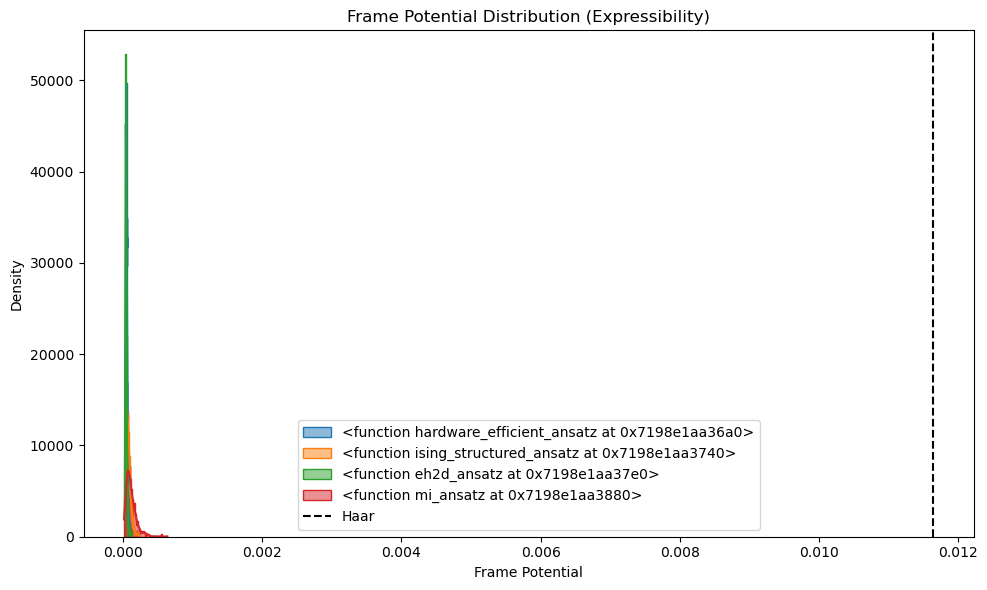

In [1]:
import pennylane as qml, jax, jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import itertools, sys, os
sys.path.append('../..')
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)
shots = None


def make_state_fn(ansatz, hyper_kwargs):
    @qml.qnode(dev, interface="jax")
    def circuit(params):
        ansatz(params, wires=range(n_qubits), **hyper_kwargs)
        return qml.state()
    return circuit

def frame_potential_2(states):
    states = states / jnp.linalg.norm(states, axis=1, keepdims=True)
    overlap = states @ states.conj().T
    fp2 = jnp.mean(jnp.abs(overlap) ** 4)
    return float(fp2)

from src.circuits.ansatz1 import hardware_efficient_ansatz
from src.circuits.ansatz2 import ising_structured_ansatz
from src.circuits.ansatz3 import eh2d_ansatz
from src.circuits.ansatz4 import mi_ansatz
from src.train.training import ansatz_set

ansatzs = [hardware_efficient_ansatz, ising_structured_ansatz, eh2d_ansatz, mi_ansatz]
param_sampler = lambda k, shape: jax.random.normal(k, shape, dtype=jnp.float64)
K = 500
all_fp2 = []
labels = []
for a in ansatzs:
    ansatz_fn, L, pc, idx = ansatz_set(a)
    circ = make_state_fn(ansatz_fn, {"L": L})
    key = jax.random.PRNGKey(0)
    params_all = param_sampler(key, (K, pc))   # (K, pc)
    circ_vmapped = jax.vmap(circ)
    states = circ_vmapped(params_all)          # (K, 2**n)
    fp2 = frame_potential_2(states)
    haar_fp2 = (3*(2**n_qubits) - 2) / ((2**n_qubits) * (2**n_qubits + 1))
    express = abs(fp2 - haar_fp2)
    print(f"Ansatz {idx}: FP2={fp2:.4e}  |ΔFP2|={express:.4e}")
    fp2s = []
    for i in range(K):
        others = jnp.concatenate([states[:i], states[i+1:]], axis=0)
        overlap = states[i] @ others.conj().T
        fp2 = jnp.mean(jnp.abs(overlap) ** 4)
        fp2s.append(float(fp2))
    all_fp2.append(fp2s)
    labels.append(a)



# 画histogram

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
for fp2s, label in zip(all_fp2, labels):
    sns.histplot(fp2s, label=label, bins=40, kde=True, stat='density', element='step')
haar_fp2 = (3 * (2 ** n_qubits) - 2) / ((2 ** n_qubits) * (2 ** n_qubits + 1))
plt.axvline(haar_fp2, ls="--", color="black", label="Haar")
plt.xlabel("Frame Potential")
plt.ylabel("Density")
plt.title("Frame Potential Distribution (Expressibility)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

n_qubits = 8
K = 1000  # 样本数
param_sampler = lambda k, shape: jax.random.normal(k, shape, dtype=jnp.float64)

from src.circuits.ansatz1 import hardware_efficient_ansatz
from src.circuits.ansatz2 import ising_structured_ansatz
from src.circuits.ansatz3 import eh2d_ansatz
from src.circuits.ansatz4 import mi_ansatz
from src.train.training import ansatz_set

ansatzs = [
    ("Hardware", hardware_efficient_ansatz),
    ("Ising2D", ising_structured_ansatz),
    ("EH2D", eh2d_ansatz),
    ("MI", mi_ansatz)
]

all_fp2 = []
labels = []

for name, a in ansatzs:
    ansatz_fn, L, pc, idx = ansatz_set(a)
    circ = make_state_fn(ansatz_fn, {"L": L})
    key = jax.random.PRNGKey(42 + idx)
    keys = jax.random.split(key, K)
    # 每个样本一个state
    states = [circ(param_sampler(k, (pc,))) for k in keys]
    states = jnp.stack(states)
    # 计算每个state和其它state的frame potential
    fp2s = []
    for i in range(K):
        others = jnp.concatenate([states[:i], states[i+1:]], axis=0)
        overlap = states[i] @ others.conj().T
        fp2 = jnp.mean(jnp.abs(overlap) ** 4)
        fp2s.append(float(fp2))
    all_fp2.append(fp2s)
    labels.append(name)




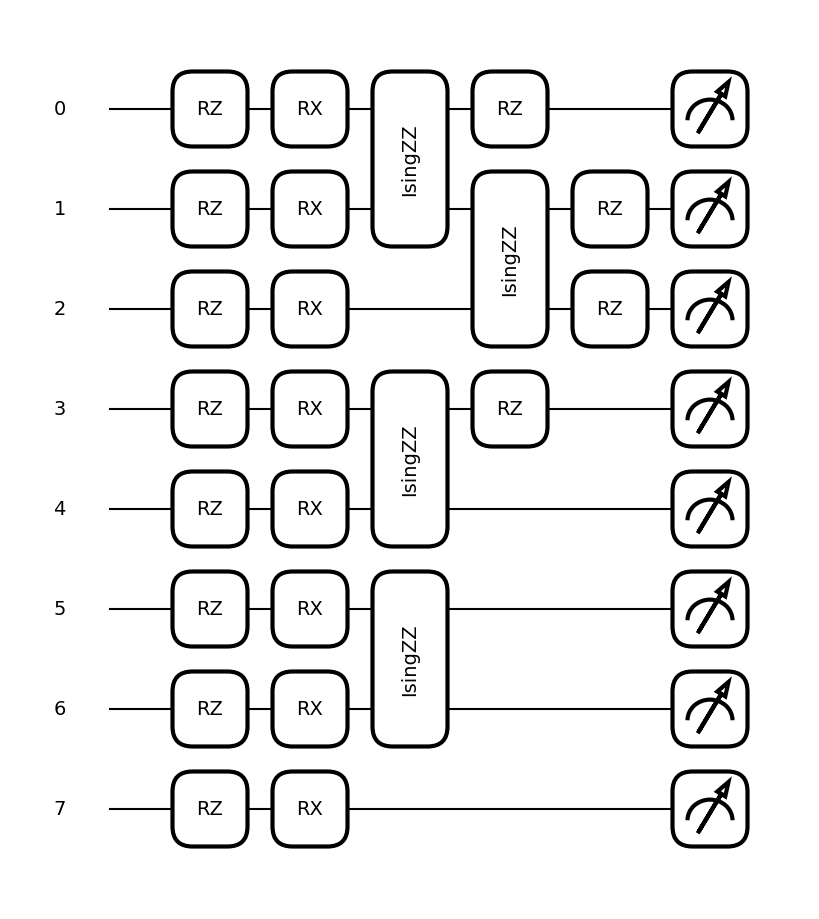

In [19]:
import pennylane as qml
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

from src.circuits.ansatz1 import hardware_efficient_ansatz
from src.circuits.ansatz2 import ising_structured_ansatz
from src.circuits.ansatz3 import eh2d_ansatz
from src.circuits.ansatz4 import mi_ansatz

import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np

n = 8
L = 1
k = 6  # 用 6 条边举例，实际实验你可以用 24
wires = list(range(n))
# 举例用前面6条边（完全连接的话自己生成下）
mi_edges = [(0,1), (1,2), (3,4), (5,6)]  # 你可以用真实的 top_idx 排序
num_params = L * (2 * n + len(mi_edges)) + 4  # L层，每层 2n + k，最后加4

params = np.random.randn(num_params)

def mi_ansatz_layer(params, wires=wires, mi_edges=mi_edges, L=1):
    ptr = 0
    for _ in range(L):
        # Single-qubit
        for w in wires:
            qml.RZ(params[ptr], wires=w); ptr += 1
            qml.RX(params[ptr], wires=w); ptr += 1
        # Entanglers
        for (i, j) in mi_edges:
            qml.IsingZZ(params[ptr], wires=[wires[i], wires[j]]); ptr += 1
    # Global RZs
    for k in range(4):
        qml.RZ(params[ptr], wires=wires[k % n]); ptr += 1

dev = qml.device("default.qubit", wires=n)

@qml.qnode(dev)
def circuit(params):
    mi_ansatz_layer(params)
    return [qml.expval(qml.PauliZ(w) ) for w in wires]

fig, ax = qml.draw_mpl(circuit)(params)
fig.savefig("mi_ansatz_layer.png", dpi=300)
plt.show()

